# The main algorithm for regression in PEST is the Gauss-Levenberg-Marquardt (GLM)  algorithm



In [1]:
%matplotlib inline
import os
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyemu

import xsect_setup
import response_surface as resurf

copy the model files over

In [2]:
xsect_setup.setup_model()

In [3]:
working_dir = xsect_setup.WORKING_DIR
pst_name = xsect_setup.PST_NAME

## Let's open up the `PST` file and check out the parameters

In [4]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name))

In [5]:
inpst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,extra
parnme,,,,,,,,,,,
hk1,hk1,log,factor,2.5,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1,NaN
cal_flux,cal_flux,log,factor,0.5,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1,NaN
fore_flux,fore_flux,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1,NaN


## We need to fix forecast flux and put reasonable bounds on the other parameters

In [6]:
inpst.parameter_data.loc['hk1', 'parlbnd'] = 1.0
inpst.parameter_data.loc['hk1', 'parubnd'] = 25.0
inpst.parameter_data.loc['cal_flux', 'parlbnd'] = 0.001
inpst.parameter_data.loc['cal_flux', 'parubnd'] = 5
inpst.parameter_data.loc['fore_flux', 'partrans'] = 'fixed'
inpst.write(os.path.join(working_dir,pst_name))
inpst.parameter_data


,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,extra
parnme,,,,,,,,,,,
hk1,hk1,log,factor,2.5,1.000000e+00,2.500000e+01,pargp,1.0,0.0,1,NaN
cal_flux,cal_flux,log,factor,0.5,1.000000e-03,5.000000e+00,pargp,1.0,0.0,1,NaN
fore_flux,fore_flux,fixed,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1,NaN


## run the response surface function

In [7]:
resurf.run_respsurf(['hk1', 'cal_flux'], pstfile=pst_name, WORKING_DIR=working_dir)

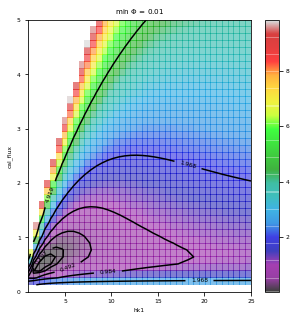

In [8]:
fig, ax = resurf.plot_response_surface(parnames=['hk1', 'cal_flux'], 
                             pstfile=pst_name, WORKING_DIR=working_dir,
                            nanthresh = 10);

## Let's evaluate the impact of Lambda on regression (regularization included)

In [9]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name))
# turn off the Maquardt lambda
inpst.pestpp_options['lambdas']=0.0
inpst.pestpp_options['lambda_scale_fac']=1.0
inpst.pestpp_options['upgrade_augment']='False'

inpst.parameter_data.loc['fore_flux', 'partrans'] = 'fixed'
# set the starting values up in the corner of parameter space
inpst.parameter_data.loc['hk1', 'parval1'] = 20.0
inpst.parameter_data.loc['cal_flux', 'parval1'] = 4.0
inpst.control_data.noptmax=250
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.nolam.pst')))

In [10]:
os.chdir(working_dir)
pyemu.helpers.start_slaves('.', 'pestpp', 
                           pst_name.replace('.pst','.nolam.pst'), 
                           num_slaves=5, master_dir='.')
os.chdir("..")


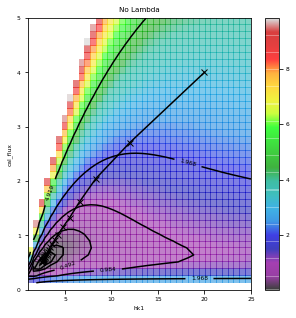

In [11]:
fig, ax = resurf.plot_response_surface(parnames=['hk1', 'cal_flux'], 
                             pstfile=pst_name, WORKING_DIR=working_dir,
                            nanthresh = 10);
pars, obfun = resurf.add_trajectory_to_plot(fig,ax, 'nolam','No Lambda', working_dir, pst_name)

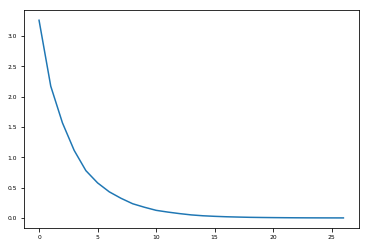

In [12]:
obfun.total_phi.plot()

# Let's try a small value `(1.0)` for Lambda

In [13]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name.replace('.nolam.pst','.lam1.0.pst')))
# set the Maquardt lambda to 1.0
inpst.pestpp_options['lambdas']=1.0
inpst.pestpp_options['lambda_scale_fac']=1.0
inpst.pestpp_options['upgrade_augment']='False'

inpst.parameter_data.loc['hk1', 'parval1'] = 20.0
inpst.parameter_data.loc['cal_flux', 'parval1'] = 4.0
inpst.control_data.noptmax=250
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.lam1.0.pst')))

In [14]:
os.chdir(working_dir)
pyemu.helpers.start_slaves('.', 'pestpp', 
                           pst_name.replace('.pst','.lam1.0.pst'), 
                           num_slaves=5, master_dir='.')
os.chdir("..")

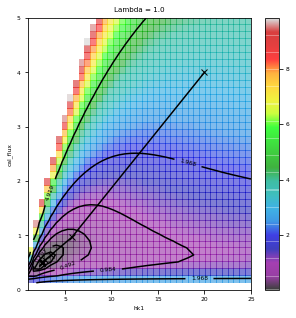

In [15]:
fig, ax = resurf.plot_response_surface(parnames=['hk1', 'cal_flux'], 
                             pstfile=pst_name, WORKING_DIR=working_dir,
                            nanthresh = 10);
pars, obfun = resurf.add_trajectory_to_plot(fig,ax, 'lam1.0','Lambda = 1.0', working_dir, pst_name)

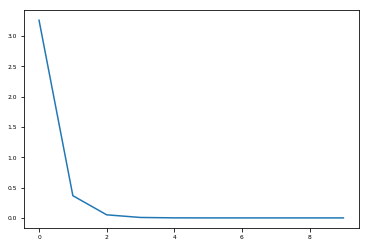

In [16]:
obfun.total_phi.plot()

# Let's try a really big value value `(50.0)` for Lambda

In [17]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name.replace('.nolam.pst','.lam50.0.pst')))
# set the Maquardt lambda to 1.0
inpst.pestpp_options['lambdas']=50.0
inpst.pestpp_options['lambda_scale_fac']=1.0
inpst.pestpp_options['upgrade_augment']='False'

inpst.parameter_data.loc['hk1', 'parval1'] = 20.0
inpst.parameter_data.loc['cal_flux', 'parval1'] = 4.0
# let's make sure it keeps going even with tiny steps
inpst.control_data.noptmax=550
inpst.control_data.phiredstp=0.000001
inpst.control_data.relparstp=0.000001
inpst.control_data.nphistp=6
inpst.control_data.nrelpar=6
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.lam50.0.pst')))

In [18]:
os.chdir(working_dir)
pyemu.helpers.start_slaves('.', 'pestpp', 
                           pst_name.replace('.pst','.lam50.0.pst'), 
                           num_slaves=5, master_dir='.')
os.chdir("..")

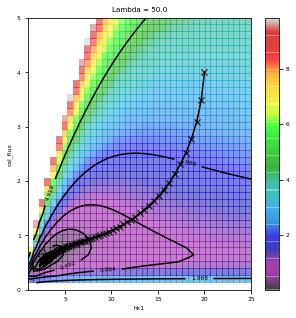

In [19]:
fig, ax = resurf.plot_response_surface(parnames=['hk1', 'cal_flux'], 
                             pstfile=pst_name, WORKING_DIR=working_dir,
                            nanthresh = 10);
pars, obfun = resurf.add_trajectory_to_plot(fig,ax, 'lam50.0','Lambda = 50.0', working_dir, pst_name)

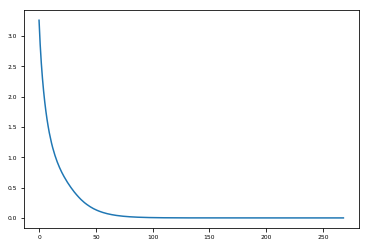

In [20]:
obfun.total_phi.plot()

In [21]:
pars.tail()

,iteration,hk1,cal_flux,fore_flux
264,264,2.50174,0.500100,1
265,265,2.50174,0.500094,1
266,266,2.50152,0.500125,1
267,267,2.50152,0.500117,1
268,268,2.50151,0.500109,1


In [22]:
obfun.tail()

,iteration,model_runs_completed,total_phi,measurement_phi,regularization_phi,obgnme,obgnme_pi
264,264,1315,3.037030e-08,3.037030e-08,0,0.000000,3.037030e-08
265,265,1320,1.026460e-06,1.026460e-06,0,0.000001,2.646030e-08
266,266,1325,4.715000e-08,4.715000e-08,0,0.000000,4.715000e-08
267,267,1330,4.110240e-08,4.110240e-08,0,0.000000,4.110240e-08
268,268,1335,3.583040e-08,3.583040e-08,0,0.000000,3.583040e-08
